# XGBoost

In [40]:
# Importing required libraries
import numpy as np
import pandas as pd, datetime
import seaborn as sns
from statsmodels.tsa.stattools import adfuller
import matplotlib.pyplot as plt
get_ipython().run_line_magic('matplotlib', 'inline')
from time import time
import os
from math import sqrt
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
import itertools
import statsmodels.api as sm
from statsmodels.tsa.stattools import acf,pacf
from statsmodels.tsa.arima_model import  ARIMA
from sklearn import model_selection
from sklearn.metrics import mean_squared_error, r2_score
from pandas import DataFrame
import xgboost as xgb
from fbprophet import Prophet
import warnings
import fbprophet
warnings.filterwarnings('ignore')

In [7]:
## load the data
df = pd.read_csv('data-for-test2.csv')
df

,datetime,irradiance,humidity,temperature,energy
0,1/1/2016 0:00,0.000,72.7,21.556,0.00
1,1/1/2016 0:05,0.000,73.0,21.556,0.00
2,1/1/2016 0:10,0.396,73.3,21.500,0.00
3,1/1/2016 0:15,0.791,73.3,21.389,0.00
4,1/1/2016 0:20,0.396,73.3,21.278,0.00
...,...,...,...,...,...
199995,1/7/2018 17:15,193.286,58.1,25.556,7.73
199996,1/7/2018 17:20,557.061,57.1,25.889,8.01
199997,1/7/2018 17:25,528.811,58.2,25.667,10.39
199998,1/7/2018 17:30,347.915,58.3,25.889,8.74


In [36]:
df["month"] = pd.DatetimeIndex(df['datetime']).month

In [38]:
df["year"] = pd.DatetimeIndex(df['datetime']).year

In [39]:
df

,datetime,irradiance,humidity,temperature,energy,month,year
0,1/1/2016 0:00,0.000,72.7,21.556,0.00,1,2016
1,1/1/2016 0:05,0.000,73.0,21.556,0.00,1,2016
2,1/1/2016 0:10,0.396,73.3,21.500,0.00,1,2016
3,1/1/2016 0:15,0.791,73.3,21.389,0.00,1,2016
4,1/1/2016 0:20,0.396,73.3,21.278,0.00,1,2016
...,...,...,...,...,...,...,...
199995,1/7/2018 17:15,193.286,58.1,25.556,7.73,1,2018
199996,1/7/2018 17:20,557.061,57.1,25.889,8.01,1,2018
199997,1/7/2018 17:25,528.811,58.2,25.667,10.39,1,2018
199998,1/7/2018 17:30,347.915,58.3,25.889,8.74,1,2018


In [21]:
df['datetime'] = pd.to_datetime(df['datetime'])

In [27]:
df.set_index(['datetime'])

,irradiance,humidity,temperature,energy
datetime,,,,
2016-01-01 00:00:00,0.000,72.7,21.556,0.00
2016-01-01 00:05:00,0.000,73.0,21.556,0.00
2016-01-01 00:10:00,0.396,73.3,21.500,0.00
2016-01-01 00:15:00,0.791,73.3,21.389,0.00
2016-01-01 00:20:00,0.396,73.3,21.278,0.00
...,...,...,...,...
2018-01-07 17:15:00,193.286,58.1,25.556,7.73
2018-01-07 17:20:00,557.061,57.1,25.889,8.01
2018-01-07 17:25:00,528.811,58.2,25.667,10.39


## Trend chart of Energy vs. Each Month 

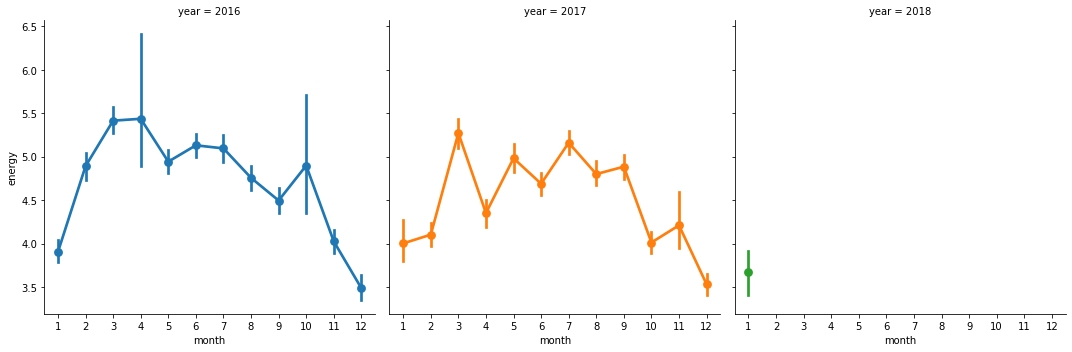

In [44]:
#making line plot to see trends
sns.factorplot(data = df, x ="month", y = "energy", hue = "year",
               col = "year")

## Time series data stationary test

In [45]:
# Function to test the stationarity
def test_stationarity(timeseries):
    
    # Determing rolling statistics
    roll_mean = timeseries.rolling(window=7).mean()
    roll_std = timeseries.rolling(window=7).std()
# Plotting rolling statistics:
    orig = plt.plot(timeseries.resample('W').mean(), color='blue',label='Original')
    mean = plt.plot(roll_mean.resample('W').mean(), color='red', label='Rolling Mean')
    std = plt.plot(roll_std.resample('W').mean(), color='green', label = 'Rolling Std')
    plt.legend(loc='best')
    plt.show(block=False)
    
  # Performing Dickey-Fuller test:
    print('Results of Dickey-Fuller Test:')
    result = adfuller(timeseries, autolag='AIC')
    print('ADF Statistic: %f' % result[0])
    print('p-value: %f' % result[1])
    print('Critical Values:')
    for key, value in result[4].items():
           print(key, value)

In [47]:
df['datetime'] = pd.to_datetime(df['datetime'])

In [48]:
df.set_index(['datetime'])

,irradiance,humidity,temperature,energy,month,year
datetime,,,,,,
2016-01-01 00:00:00,0.000,72.7,21.556,0.00,1,2016
2016-01-01 00:05:00,0.000,73.0,21.556,0.00,1,2016
2016-01-01 00:10:00,0.396,73.3,21.500,0.00,1,2016
2016-01-01 00:15:00,0.791,73.3,21.389,0.00,1,2016
2016-01-01 00:20:00,0.396,73.3,21.278,0.00,1,2016
...,...,...,...,...,...,...
2018-01-07 17:15:00,193.286,58.1,25.556,7.73,1,2018
2018-01-07 17:20:00,557.061,57.1,25.889,8.01,1,2018
2018-01-07 17:25:00,528.811,58.2,25.667,10.39,1,2018


In [3]:
df_energy = df[['datetime', 'energy']]
df_energy = df_energy.set_index(['datetime'])
df_energy

,energy
datetime,
1/1/2016 0:00,0.00
1/1/2016 0:05,0.00
1/1/2016 0:10,0.00
1/1/2016 0:15,0.00
1/1/2016 0:20,0.00
...,...
1/7/2018 17:15,7.73
1/7/2018 17:20,8.01
1/7/2018 17:25,10.39


## Rolling mean: used to assess the model stability over time
## Dicky-Fuller test: statistical data summary

In [62]:
# Function to test the stationarity
def test_stationarity(timeseries):
    
    # Determing rolling statistics
    roll_mean = timeseries.rolling(window=7).mean()
    roll_std = timeseries.rolling(window=7).std()
# Plotting rolling statistics:
    orig = plt.plot(timeseries.resample('W').mean(), color='blue',label='Original')
    mean = plt.plot(roll_mean.resample('W').mean(), color='red', label='Rolling Mean')
    std = plt.plot(roll_std.resample('W').mean(), color='green', label = 'Rolling Std')
    plt.legend(loc='best')
    plt.show(block=False)
    
  # Performing Dickey-Fuller test:
    print('Results of Dickey-Fuller Test:')
    result = adfuller(timeseries, autolag='AIC')
    print('ADF Statistic: %f' % result[0])
    print('p-value: %f' % result[1])
    print('Critical Values:')
    for key, value in result[4].items():
           print(key, value)

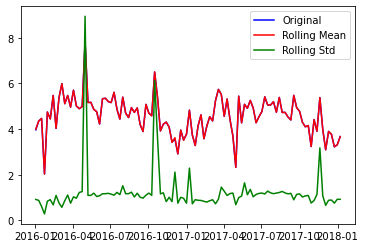

Results of Dickey-Fuller Test:
ADF Statistic: -55.004266
p-value: 0.000000
Critical Values:
1% -3.4303827103310676
5% -2.8615544575334875
10% -2.566777695225296


In [63]:
test_stationarity(df_energy)

## We can see above the plot and statistical test; the mean and variation does not change much with time. We don't need to perform any transformation.

In [68]:
# Plotting seasonality and trend
def plot_timeseries(energy):
    fig, axes = plt.subplots(2, 1, sharex=True, sharey=False)
    fig.set_figheight(10)
    fig.set_figwidth(15)
    decomposition= seasonal_decompose(energy, model = 'additive',freq=365)
    estimated_trend = decomposition.trend
    estimated_seasonal = decomposition.seasonal
    estimated_residual = decomposition.resid
    
    axes[1].plot(estimated_seasonal, 'g', label='Seasonality')
    axes[1].legend(loc='upper left');
    
    axes[0].plot(estimated_trend, label='Trend')
    axes[0].legend(loc='upper left');
    plt.title('Decomposition Plots')

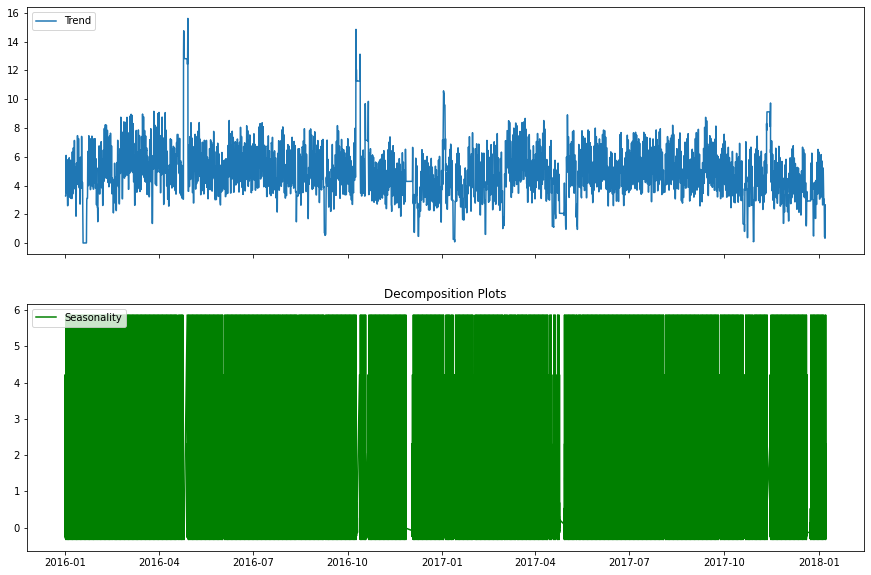

In [69]:
plot_timeseries(df_energy)

## XGBoost

In [13]:
df
mycol= ["datetime", "energy"]

In [15]:
# Splitting the data
features = df.drop(mycol, axis = 1)
target = df["energy"]
X_train, X_test, y_train, y_test = model_selection.train_test_split(features, target, test_size = 0.20)

## Baseline Model

In [16]:
# Tuning parameters - using default metrics
params = {'max_depth':6, "booster": "gbtree", 'eta':0.3, 'objective':'reg:linear'}
dtrain = xgb.DMatrix(X_train, y_train)
dtest = xgb.DMatrix(X_test, y_test)
watchlist = [(dtrain, 'train'), (dtest, 'eval')]
# Training the model
xgboost = xgb.train(params, dtrain, 100, evals=watchlist,early_stopping_rounds= 100, verbose_eval=True)
         
# Making predictions
preds = xgboost.predict(dtest)

[11:18:57] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.2.0/src/objective/regression_obj.cu:174: reg:linear is now deprecated in favor of reg:squarederror.
[0]	train-rmse:11.74579	eval-rmse:6.33824
Multiple eval metrics have been passed: 'eval-rmse' will be used for early stopping.

Will train until eval-rmse hasn't improved in 100 rounds.
[1]	train-rmse:10.31706	eval-rmse:5.24189
[2]	train-rmse:9.26695	eval-rmse:4.61592
[3]	train-rmse:8.95143	eval-rmse:4.28108
[4]	train-rmse:8.27952	eval-rmse:4.10546
[5]	train-rmse:7.92904	eval-rmse:4.04507
[6]	train-rmse:7.55303	eval-rmse:4.01352
[7]	train-rmse:7.24958	eval-rmse:4.06980
[8]	train-rmse:7.10150	eval-rmse:4.12792
[9]	train-rmse:7.05360	eval-rmse:4.19304
[10]	train-rmse:6.92011	eval-rmse:4.19043
[11]	train-rmse:6.86643	eval-rmse:4.23486
[12]	train-rmse:6.77979	eval-rmse:4.23363
[13]	train-rmse:6.76736	eval-rmse:4.29905
[14]	train-rmse:6.66890	eval-rmse:4.29859
[15]	train-rmse:6.47054	eval-rmse:4.39278
[16]	train-rmse

In [17]:
# RMSE of model
rms_xgboost = sqrt(mean_squared_error(y_test, preds))
print("Root Mean Squared Error for XGBoost:", rms_xgboost)

Root Mean Squared Error for XGBoost: 4.531486220208842


In [18]:
# Tuning parameters
params_2 = {'max_depth':10, 'eta':0.1,  'gamma': 2}
dtrain = xgb.DMatrix(X_train, y_train)
dtest = xgb.DMatrix(X_test, y_test)
watchlist = [(dtrain, 'train'), (dtest, 'eval')]
# Training the model
xgboost_2 = xgb.train(params_2, dtrain, 100, evals=watchlist,early_stopping_rounds= 100, verbose_eval=True)
         
# Making predictions
preds_2 = xgboost_2.predict(dtest)

[0]	train-rmse:13.01926	eval-rmse:7.52154
Multiple eval metrics have been passed: 'eval-rmse' will be used for early stopping.

Will train until eval-rmse hasn't improved in 100 rounds.
[1]	train-rmse:12.30428	eval-rmse:7.01742
[2]	train-rmse:11.64157	eval-rmse:6.54953
[3]	train-rmse:11.05183	eval-rmse:6.14553
[4]	train-rmse:10.51235	eval-rmse:5.85910
[5]	train-rmse:10.02533	eval-rmse:5.64726
[6]	train-rmse:9.57887	eval-rmse:5.40157
[7]	train-rmse:9.17641	eval-rmse:5.19478
[8]	train-rmse:8.79317	eval-rmse:5.01940
[9]	train-rmse:8.45802	eval-rmse:4.87578
[10]	train-rmse:8.15434	eval-rmse:4.75351
[11]	train-rmse:7.87864	eval-rmse:4.65401
[12]	train-rmse:7.60979	eval-rmse:4.56953
[13]	train-rmse:7.36494	eval-rmse:4.50049
[14]	train-rmse:7.13705	eval-rmse:4.44841
[15]	train-rmse:6.93340	eval-rmse:4.40221
[16]	train-rmse:6.74333	eval-rmse:4.37010
[17]	train-rmse:6.57420	eval-rmse:4.33928
[18]	train-rmse:6.41584	eval-rmse:4.32119
[19]	train-rmse:6.27161	eval-rmse:4.30875
[20]	train-rmse:6.14

In [19]:
# RMSE of model
rms_xgboost_2 = sqrt(mean_squared_error(y_test, preds_2))
print("Root Mean Squared Error for XGBoost:", rms_xgboost_2)

Root Mean Squared Error for XGBoost: 4.360402815552415


## Feature Importance

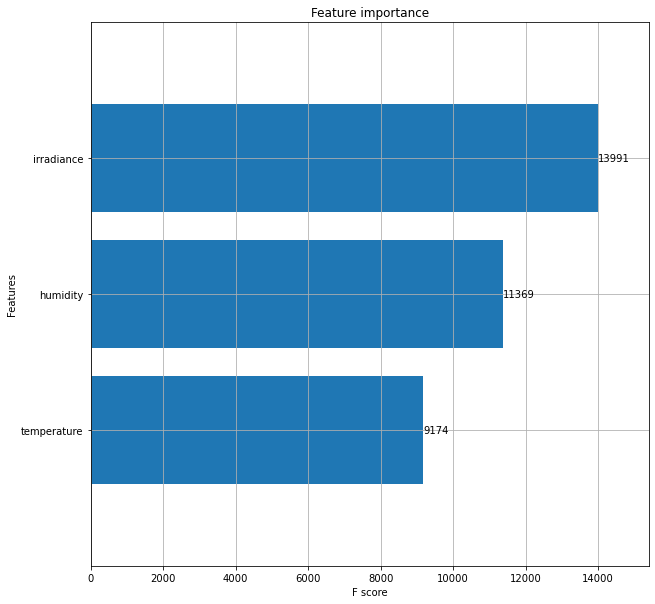

In [20]:
# Let's see the feature importance
fig, ax = plt.subplots(figsize=(10,10))
xgb.plot_importance(xgboost_2, max_num_features=50, height=0.8, ax=ax)
plt.show()